In [1]:
import gzip
import numpy as np
import pandas as pd
import random
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')
from gensim import corpora, models
from sklearn import model_selection
from sklearn import cross_validation
from tabulate import tabulate
import pyLDAvis.gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn import svm

/Users/austinbrian/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [160]:
data = pd.read_csv('../data/sent_data.csv')
cfpb = pd.read_csv('../data/cfpb.csv')
data['date_received'] = pd.to_datetime(data['date_received'])
cfpb['date_received'] = pd.to_datetime(cfpb['date_received'])
wf = data[data.company == 'WELLS FARGO BANK, NATIONAL ASSOCIATION']
wf.drop('company',axis=1,inplace=True)

/Users/austinbrian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [72]:
id2word = corpora.Dictionary.load('../models/complaints_full.dict')
corpus = corpora.MmCorpus('../models/complaints_full.mm')

# load in 50-topic model
model = models.ldamodel.LdaModel.load('../topic_tests/model_50_topics.model')

stop = set(stopwords.words('english') + list(string.punctuation))
stemmer = PorterStemmer()
re_punct = re.compile('[' + ''.join(string.punctuation) + ']')

def preprocess(text):
    try:
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [t for t in tokens if not t in stop]
        tokens = [re.sub(re_punct, '', t) for t in tokens]
        tokens = [re.sub(r'\d','',t) for t in tokens] # there are random digits in this dataset
        tokens = [re.sub(r'xx+','',t) for t in tokens] # there are also random xs all through it for anonymization
        tokens = [t for t in tokens if len(t) > 2]
        tokens = [stemmer.stem(t) for t in tokens]
        if len(tokens) == 0:
            return None
        else:
            return ' '.join(tokens)
    except:
        return None

In [73]:
wf.head(12)

,complaint_what_happened,product,date_received,tokens,topic
39,XXXX has wrongfully placed an account in colle...,5,2017-03-06,wrong place account collect indic owe water bi...,28
229,I have been an XXXX customer since it acquired...,7,2017-03-06,custom sinc acquir late cel phone number sinc ...,28
322,In XX/XX/2015 I had a checking account with Ba...,0,2017-04-06,check account bank america time work local pai...,28
351,A computer showed up at my home that I did not...,7,2017-03-06,comput show home order contact sender said wou...,28
390,I am writing in reference to a collection agen...,7,2017-03-07,write refer collect agenc recent receiv two le...,28
642,I 've been asking Equifax to assist me with co...,5,2017-03-08,ask equifax assist correct inform credit repor...,17
872,I have been trying to refinance my home since ...,10,2017-03-09,tri refin home sinc ditech sever month go back...,11
894,"Man by the name of "" XXXX XXXX '' continously ...",7,2017-03-09,man name contin call spoke tri get settl debt ...,28
1845,there is a child support item on my credit rep...,5,2017-03-29,child support item credit report schedul fall ...,17
1966,"After reviewing my credit report, I found that...",15,2017-03-07,review credit report found student loan report...,21


## Query the model

In [74]:
query = wf.loc[351,'complaint_what_happened']
query = preprocess(query).split()

In [75]:
new_id2word = corpora.Dictionary()
_ = new_id2word.merge_with(id2word) # merges unseen words into the overall model's bag of words
query = new_id2word.doc2bow(query)
print(query)

[(2260, 1), (2551, 1), (2728, 1), (7815, 2), (8220, 1), (10050, 1), (12833, 1), (13157, 1), (13510, 1), (17537, 1), (19304, 1), (19315, 1), (20316, 1), (20562, 1), (21614, 1), (25925, 1), (26663, 2), (27570, 1), (28865, 1), (30618, 1), (34623, 1), (37761, 1), (40275, 1), (43330, 2), (44402, 1), (55040, 2), (57191, 2), (58887, 1)]


In [76]:
topic_relevance = list(sorted(model[query], key=lambda x: -x[1]))
print('Most relevant: {}'.format(topic_relevance[0]))
print('Least relevant: {}'.format(topic_relevance[-1]))

Most relevant: (7, 0.14659364403713293)
Least relevant: (41, 0.03155200920068129)


In [77]:
# Build query into a single function
def ldaquery(text, return_topic=0):
    query = text
    query = preprocess(query).split()
    new_id2word = corpora.Dictionary()
    _ = new_id2word.merge_with(id2word) 
    query = new_id2word.doc2bow(query)
    topic_relevance = list(sorted(model[query],key=lambda x: -x[-1]))
    try:
        return topic_relevance[return_topic][0] # returns most relevant by default
    except IndexError:
        pass

In [78]:
ldaquery(wf.loc[1968,'complaint_what_happened'])

38

In [162]:
# apply function that lists top topic to Wells Fargo complaints dataframe
wf['topic'] = wf['complaint_what_happened'].progress_map(ldaquery)



progress-bar:   0%|          | 0/1382 [00:00<?, ?it/s]

progress-bar:   0%|          | 2/1382 [00:00<05:15,  4.38it/s]


progress-bar:   0%|          | 3/1382 [00:00<04:55,  4.66it/s]

progress-bar:   0%|          | 4/1382 [00:00<04:48,  4.77it/s]

progress-bar:   0%|          | 5/1382 [00:01<04:37,  4.96it/s]

progress-bar:   0%|          | 6/1382 [00:01<04:36,  4.97it/s]

progress-bar:   1%|          | 7/1382 [00:01<04:30,  5.08it/s]

progress-bar:   1%|          | 8/1382 [00:01<04:28,  5.11it/s]

progress-bar:   1%|          | 9/1382 [00:01<04:33,  5.01it/s]

progress-bar:   1%|          | 10/1382 [00:02<04:32,  5.04it/s]

progress-bar:   1%|          | 11/1382 [00:02<04:28,  5.10it/s]

progress-bar:   1%|          | 12/1382 [00:02<04:25,  5.16it/s]

progress-bar:   1%|          | 13/1382 [00:02<04:22,  5.21it/s]

progress-bar:   1%|          | 14/1382 [00:02<04:15,  5.35it/s]

progress-bar:   1%|          | 15/1382 [00:02<04:14,  5.38it/s]

progress-bar:   1%|          | 16/1382 

In [80]:
# apply function to the rest of the data while we're at it (8 mins)
# This takes 8 hours, so let's not.
# data['topic'] = data['complaint_what_happened'].progress_map(ldaquery)

In [81]:
wf.head()

,complaint_what_happened,product,date_received,tokens,topic
39,XXXX has wrongfully placed an account in colle...,5,2017-03-06,wrong place account collect indic owe water bi...,27
229,I have been an XXXX customer since it acquired...,7,2017-03-06,custom sinc acquir late cel phone number sinc ...,31
322,In XX/XX/2015 I had a checking account with Ba...,0,2017-04-06,check account bank america time work local pai...,27
351,A computer showed up at my home that I did not...,7,2017-03-06,comput show home order contact sender said wou...,7
390,I am writing in reference to a collection agen...,7,2017-03-07,write refer collect agenc recent receiv two le...,14


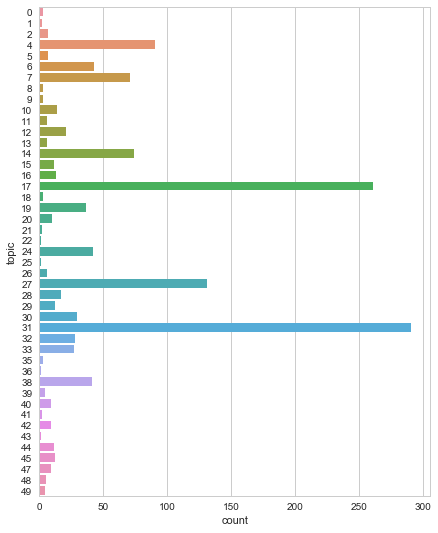

In [82]:
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(7,9))
g = sns.countplot(y=wf[wf.topic.notnull()].topic)


In [83]:
# Wells fargo enforcment
from datetime import datetime
wells_enforcement = datetime(2016,9,8)
wells_enforcement.strftime(format='%A, %B %d, %Y - %I:%M %p')

'Thursday, September 08, 2016 - 12:00 AM'

In [84]:
data.head()

,complaint_what_happened,product,date_received,tokens,company
0,I paid off another account a couple of years a...,7,2017-03-04,paid anoth account coupl year ago colbrsrv dec...,NaN
1,disputed incorrect information and accounts wi...,5,2017-03-21,disput incorrect inform account experian thitr...,NaN
2,Capital One reported my auto loan payments lat...,3,2017-03-04,capit one report auto loan payment late sever ...,"Collection Bureau Services, Inc."
3,I contacted a representative of Key Bank about...,0,2017-03-04,contact repres key bank mortgag first thing to...,NaN
4,I bought a money order from XXXX XXXX to pay a...,11,2017-03-31,bought money order pay bill found payment cred...,NaN


In [85]:
wf_after_enforcement = wf['date_received']>wells_enforcement
wf_before_enforcement = wf.date_received<wells_enforcement
wf_4_mo_before = datetime(2016,5,8)
wf_4_mo_after = datetime(2017,1,8)
wf_pd_before= (wf.date_received<wells_enforcement)&(wf.date_received>wf_4_mo_before)
wf_pd_after = (wf.date_received>wells_enforcement)&(wf.date_received<wf_4_mo_after)

In [86]:
df = pd.DataFrame()
df['before'] = wf[wf_before_enforcement].topic.value_counts()
df['pct_before'] = 100*(wf[wf_before_enforcement].topic.value_counts()/wf[wf_before_enforcement].topic.value_counts().sum())
df['after']=wf[wf_after_enforcement].topic.value_counts()
df['pct_after'] = 100*(wf[wf_after_enforcement].topic.value_counts()/wf[wf_after_enforcement].topic.value_counts().sum())
df['topic'] = [model.print_topic(i) for i in df.index]
df

,before,pct_before,after,pct_after,topic
31,194,20.529101,97.0,22.401848,"0.084*""acct"" + 0.073*""pmi"" + 0.058*""remov"" + 0..."
17,180,19.047619,79.0,18.244804,"0.099*""boa"" + 0.035*""box"" + 0.025*""equip"" + 0...."
27,95,10.052910,36.0,8.314088,"0.121*""associ"" + 0.107*""recoveri"" + 0.095*""new..."
4,64,6.772487,26.0,6.004619,"0.290*""one"" + 0.162*""capit"" + 0.057*""alli"" + 0..."
14,45,4.761905,29.0,6.697460,"0.090*""parti"" + 0.076*""third"" + 0.049*""agreeme..."
7,43,4.550265,28.0,6.466513,"0.038*""unit"" + 0.027*""bofa"" + 0.023*""regul"" + ..."
24,33,3.492063,9.0,2.078522,"0.150*""tax"" + 0.085*""lien"" + 0.053*""garnish"" +..."
6,31,3.280423,12.0,2.771363,"0.055*""payment"" + 0.039*""incom"" + 0.033*""work""..."
38,29,3.068783,12.0,2.771363,"0.090*""balanc"" + 0.072*""amount"" + 0.048*""paid""..."
19,24,2.539683,12.0,2.771363,"0.075*""court"" + 0.055*""attorney"" + 0.044*""file..."


In [91]:
for i in df.head().index:
    print "Topic {}'\n'".format(i),model.print_topic(i),'\n'

Topic 31'
' 0.084*"acct" + 0.073*"pmi" + 0.058*"remov" + 0.039*"block" + 0.030*"thru" + 0.029*"bayview" + 0.021*"dob" + 0.021*"child" + 0.021*"ive" + 0.020*"dear" 

Topic 17'
' 0.099*"boa" + 0.035*"box" + 0.025*"equip" + 0.025*"internet" + 0.023*"servic" + 0.020*"phh" + 0.017*"return" + 0.016*"instal" + 0.015*"west" + 0.013*"cabl" 

Topic 27'
' 0.121*"associ" + 0.107*"recoveri" + 0.095*"new" + 0.058*"portfolio" + 0.051*"old" + 0.043*"expir" + 0.020*"type" + 0.017*"unknown" + 0.015*"york" + 0.012*"servic" 

Topic 4'
' 0.290*"one" + 0.162*"capit" + 0.057*"alli" + 0.037*"account" + 0.030*"freedom" + 0.019*"membership" + 0.017*"user" + 0.011*"reissu" + 0.011*"capitol" + 0.010*"chrysler" 

Topic 14'
' 0.090*"parti" + 0.076*"third" + 0.049*"agreement" + 0.047*"term" + 0.036*"page" + 0.022*"consent" + 0.022*"condit" + 0.016*"disclos" + 0.015*"site" + 0.015*"exhibit" 



In [93]:
print "Before", wf[wf_pd_before].topic.value_counts().sum()
print "After",wf[wf_pd_after].topic.value_counts().sum()


Before 236
After 218


While there does seem to be a spike of complaints, overall there seem to be fewer for Wells Fargo in the four months after the consumer complaint than before it. 

In [39]:
wells_enforcement.day

8

In [95]:
wells_enforcement-pd.DateOffset(days=5, months=1,years=14)

Timestamp('2002-08-03 00:00:00')

In [65]:
data.head().date_received.count()

5

In [226]:
wf.head()

,complaint_what_happened,product,date_received,tokens,topic
39,XXXX has wrongfully placed an account in colle...,5,2017-03-06,wrong place account collect indic owe water bi...,27
229,I have been an XXXX customer since it acquired...,7,2017-03-06,custom sinc acquir late cel phone number sinc ...,31
322,In XX/XX/2015 I had a checking account with Ba...,0,2017-04-06,check account bank america time work local pai...,27
351,A computer showed up at my home that I did not...,7,2017-03-06,comput show home order contact sender said wou...,7
390,I am writing in reference to a collection agen...,7,2017-03-07,write refer collect agenc recent receiv two le...,14


In [67]:

wf_before = wells_enforcement-pd.DateOffset(months)
wf_after = wells_enforcement+pd.DateOffset(days=15)
wf_pd_before= (wf.date_received<wells_enforcement)&(wf.date_received>wf_before)
wf_pd_after = (wf.date_received>wells_enforcement)&(wf.date_received<wf_after)
df_4 = pd.DataFrame()
df_4['before'] = wf[wf_pd_before].topic.value_counts()
df_4['pct_before'] = 100*(wf[wf_pd_before].topic.value_counts()/wf[wf_pd_before].date_received.count())
df_4['after']=wf[wf_pd_after].topic.value_counts()
df_4['pct_after'] = 100*(wf[wf_pd_after].topic.value_counts()/wf[wf_pd_after].date_received.count())
df_4['topic'] = [model.print_topic(i) for i in df_4.index]

print("{} complaints before".format(wf[wf_pd_before].date_received.count()))
print("{} complaints after".format(wf[wf_pd_after].date_received.count()))

df_4

33 complaints before
31 complaints after


,before,pct_before,after,pct_after,topic
28,16,48.484848,20.0,64.516129,"0.102*""boa"" + 0.020*""child"" + 0.017*""scottrad""..."
37,5,15.151515,3.0,9.677419,"0.121*""tax"" + 0.047*""properti"" + 0.033*""unit"" ..."
29,2,6.060606,3.0,9.677419,"0.075*""modif"" + 0.044*""loan"" + 0.026*""document..."
21,2,6.060606,NaN,NaN,"0.038*""account"" + 0.037*""onlin"" + 0.035*""fund""..."
15,2,6.060606,1.0,3.225806,"0.192*""insur"" + 0.081*""cancel"" + 0.053*""polici..."
38,1,3.030303,NaN,NaN,"0.073*""issu"" + 0.037*""resolv"" + 0.029*""time"" +..."
35,1,3.030303,1.0,3.225806,"0.032*""note"" + 0.024*""servic"" + 0.019*""trust"" ..."
23,1,3.030303,NaN,NaN,"0.114*""one"" + 0.067*""capit"" + 0.055*""refund"" +..."
11,1,3.030303,NaN,NaN,"0.069*""home"" + 0.043*""mortgag"" + 0.043*""sale"" ..."
4,1,3.030303,NaN,NaN,"0.110*""well"" + 0.065*""fargo"" + 0.013*""like"" + ..."


In [87]:
len(wf[wf_before_enforcement])

945

In [ ]:
for i in df.head().index:
    print "Topic {}'\n'".format(i),model.print_topic(i),'\n'

In [192]:
# break this into a function that can test other companies, time periods

comp = 'WELLS FARGO BANK, NATIONAL ASSOCIATION'
def time_offset(cf=df,en_date=wells_enforcement,ds=0,ms=0,ys=0):
#     cf = data[data.company ==comp]     # create a company-only df
#     cf['topic'] = cf['complaint_what_happened'].progress_map(ldaquery)
    cf_post = en_date+pd.DateOffset(days=ds,months=ms,years=ys)
    cf_pre = en_date-pd.DateOffset(days=ds,months=ms,years=ys)
    
    cf_pd_before = (cf.date_received<en_date)&(cf.date_received>cf_pre)
    cf_pd_after = (cf.date_received>en_date)&(cf.date_received<cf_post)    
    
    print("{} complaints before".format(cf[cf_pd_before].topic.value_counts().sum()))
    print("{} complaints after".format(cf[cf_pd_after].topic.value_counts().sum()))
    print("Topics before: {}".format(cf[cf_pd_before].topic.nunique()))
    print("Topics after: {}".format(cf[cf_pd_after].topic.nunique()))
    df_n = pd.DataFrame()
    df_n['after']=cf[cf_pd_after].topic.value_counts()
    df_n['pct_after'] = 100*(cf[cf_pd_after].topic.value_counts()/cf[cf_pd_after].topic.value_counts().sum())
    df_n['before'] = cf[cf_pd_before].topic.value_counts()
    df_n['pct_before'] = 100*(cf[cf_pd_before].topic.value_counts()/cf[cf_pd_before].topic.value_counts().sum())
    df_n['topic'] = [model.print_topic(i) for i in df_n.index]
    for i in df_n.head().index:
        print "Topic {}'\n'".format(i),model.print_topic(i),'\n'
    return df_n

In [185]:
comp = 'OCWEN LOAN SERVICING LLC'
ocwen = data[data.company ==comp]
ocwen['topic'] = ocwen['complaint_what_happened'].map(ldaquery)
time_offset(cf=ocwen,ms=6)

KeyboardInterrupt: 

In [115]:
data[data.company==comp].sort_values(by='date_received').head()

,complaint_what_happened,product,date_received,tokens,company
143321,I have submitted several disputes to Trans Uni...,5,2015-03-19,submit sever disput tran union credit bureau r...,OCWEN LOAN SERVICING LLC
85459,I applied for a loan modification with Wells F...,10,2015-03-21,appli loan modif well fargo mortgag receiv inf...,OCWEN LOAN SERVICING LLC
147297,Experian is reporting a XXXX account that has ...,5,2015-03-25,experian report account taken ident theft,OCWEN LOAN SERVICING LLC
107558,I was charged by Volkswagen Credit XXXX for we...,2,2015-03-27,charg volkswagen credit wear tear upon return ...,OCWEN LOAN SERVICING LLC
78644,Experian has listed on my credit report a debt...,5,2015-03-28,experian list credit report debt abolish joint...,OCWEN LOAN SERVICING LLC


In [ ]:
# fig,ax = plt.subplots(1,2)
# df = df.notnull()
# sns.factorplot(df['pct_after'],ax=ax[1])
# sns.factorplot(df['pct_before'],ax=ax[0])
# fig.show()

In [193]:
time_offset(cf=wf,ms=4)

236 complaints before
218 complaints after
Topics before: 30
Topics after: 34
Topic 31'
' 0.084*"acct" + 0.073*"pmi" + 0.058*"remov" + 0.039*"block" + 0.030*"thru" + 0.029*"bayview" + 0.021*"dob" + 0.021*"child" + 0.021*"ive" + 0.020*"dear" 

Topic 17'
' 0.099*"boa" + 0.035*"box" + 0.025*"equip" + 0.025*"internet" + 0.023*"servic" + 0.020*"phh" + 0.017*"return" + 0.016*"instal" + 0.015*"west" + 0.013*"cabl" 

Topic 27'
' 0.121*"associ" + 0.107*"recoveri" + 0.095*"new" + 0.058*"portfolio" + 0.051*"old" + 0.043*"expir" + 0.020*"type" + 0.017*"unknown" + 0.015*"york" + 0.012*"servic" 

Topic 14'
' 0.090*"parti" + 0.076*"third" + 0.049*"agreement" + 0.047*"term" + 0.036*"page" + 0.022*"consent" + 0.022*"condit" + 0.016*"disclos" + 0.015*"site" + 0.015*"exhibit" 

Topic 7'
' 0.038*"unit" + 0.027*"bofa" + 0.023*"regul" + 0.021*"state" + 0.017*"challeng" + 0.016*"rule" + 0.016*"feder" + 0.015*"reserv" + 0.013*"payrol" + 0.012*"mean" 



,after,pct_after,before,pct_before,topic
31,48,22.018349,38.0,16.101695,"0.084*""acct"" + 0.073*""pmi"" + 0.058*""remov"" + 0..."
17,37,16.972477,55.0,23.305085,"0.099*""boa"" + 0.035*""box"" + 0.025*""equip"" + 0...."
27,23,10.550459,33.0,13.983051,"0.121*""associ"" + 0.107*""recoveri"" + 0.095*""new..."
14,16,7.339450,11.0,4.661017,"0.090*""parti"" + 0.076*""third"" + 0.049*""agreeme..."
7,15,6.880734,11.0,4.661017,"0.038*""unit"" + 0.027*""bofa"" + 0.023*""regul"" + ..."
4,10,4.587156,13.0,5.508475,"0.290*""one"" + 0.162*""capit"" + 0.057*""alli"" + 0..."
38,9,4.128440,5.0,2.118644,"0.090*""balanc"" + 0.072*""amount"" + 0.048*""paid""..."
24,6,2.752294,8.0,3.389831,"0.150*""tax"" + 0.085*""lien"" + 0.053*""garnish"" +..."
19,5,2.293578,7.0,2.966102,"0.075*""court"" + 0.055*""attorney"" + 0.044*""file..."
33,4,1.834862,5.0,2.118644,"0.105*""program"" + 0.075*""option"" + 0.069*""offe..."


In [233]:
model.print_topic(44)

u'0.155*"contract" + 0.142*"sign" + 0.050*"son" + 0.032*"signatur" + 0.025*"cancel" + 0.022*"asset" + 0.018*"manag" + 0.017*"account" + 0.016*"consult" + 0.013*"never"'

In [156]:
comp = 'WELLS FARGO BANK, NATIONAL ASSOCIATION'
d2 = data[data.company==comp]
len(d2[(d2.date_received<wells_enforcement)&
         (d2.date_received>wf_prior)])

68

3090 total complaints before
4896 total complaints after
236 complaints w/narrative before
218 complaints w/narrative after


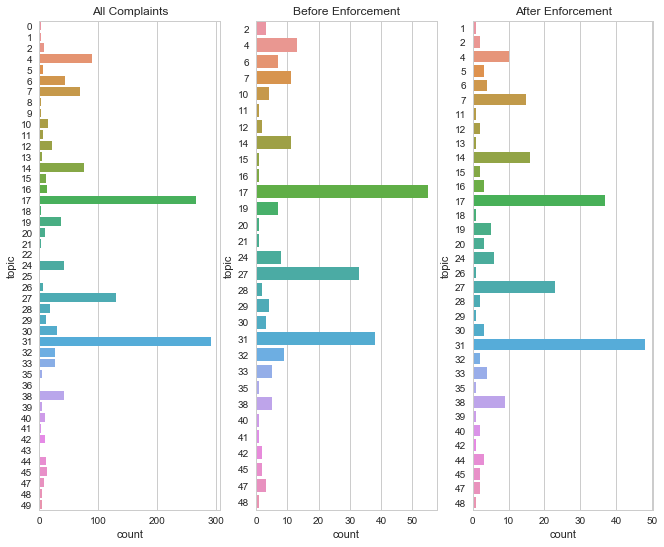

In [183]:
wf = wf[wf.topic.notnull()]

offset = pd.DateOffset(months=4) # change this to look at different lengths of time
wf_prior = wells_enforcement-offset
wf_post = wells_enforcement+offset

wf_pd_before= (wf.date_received<wells_enforcement)&(wf.date_received>wf_prior)
wf_pd_after = (wf.date_received>wells_enforcement)&(wf.date_received<wf_post)

comp = 'WELLS FARGO BANK, NATIONAL ASSOCIATION'
d2 = cfpb[cfpb.company==comp]
len(d2[(d2.date_received<wells_enforcement)&
         (d2.date_received>wf_prior)])

print("{} total complaints before".format(len(d2[(d2.date_received<wells_enforcement)&
         (d2.date_received>wf_prior)])))
print("{} total complaints after".format(len(d2[(d2.date_received>wells_enforcement)&
         (d2.date_received<wf_post)])))

print("{} complaints w/narrative before".format(wf[wf_pd_before].topic.value_counts().sum()))
print("{} complaints w/narrative after".format(wf[wf_pd_after].topic.value_counts().sum()))
    

fig,ax = plt.subplots(1,3,figsize=(11,9))
ax1 = sns.countplot(y=wf[wf_pd_before].topic,ax=ax[1])
ax2 = sns.countplot(y=wf[wf_pd_after].topic,ax=ax[2])
ax0 = sns.countplot(y=wf.topic,ax=ax[0])
ax1.title.set_text('Before Enforcement')
ax2.title.set_text('After Enforcement')
ax0.title.set_text('All Complaints')
plt.tight_layout
fig.show()

In [242]:
pwd

u'/Users/austinbrian/dev/DSI/capstone/notebooks'

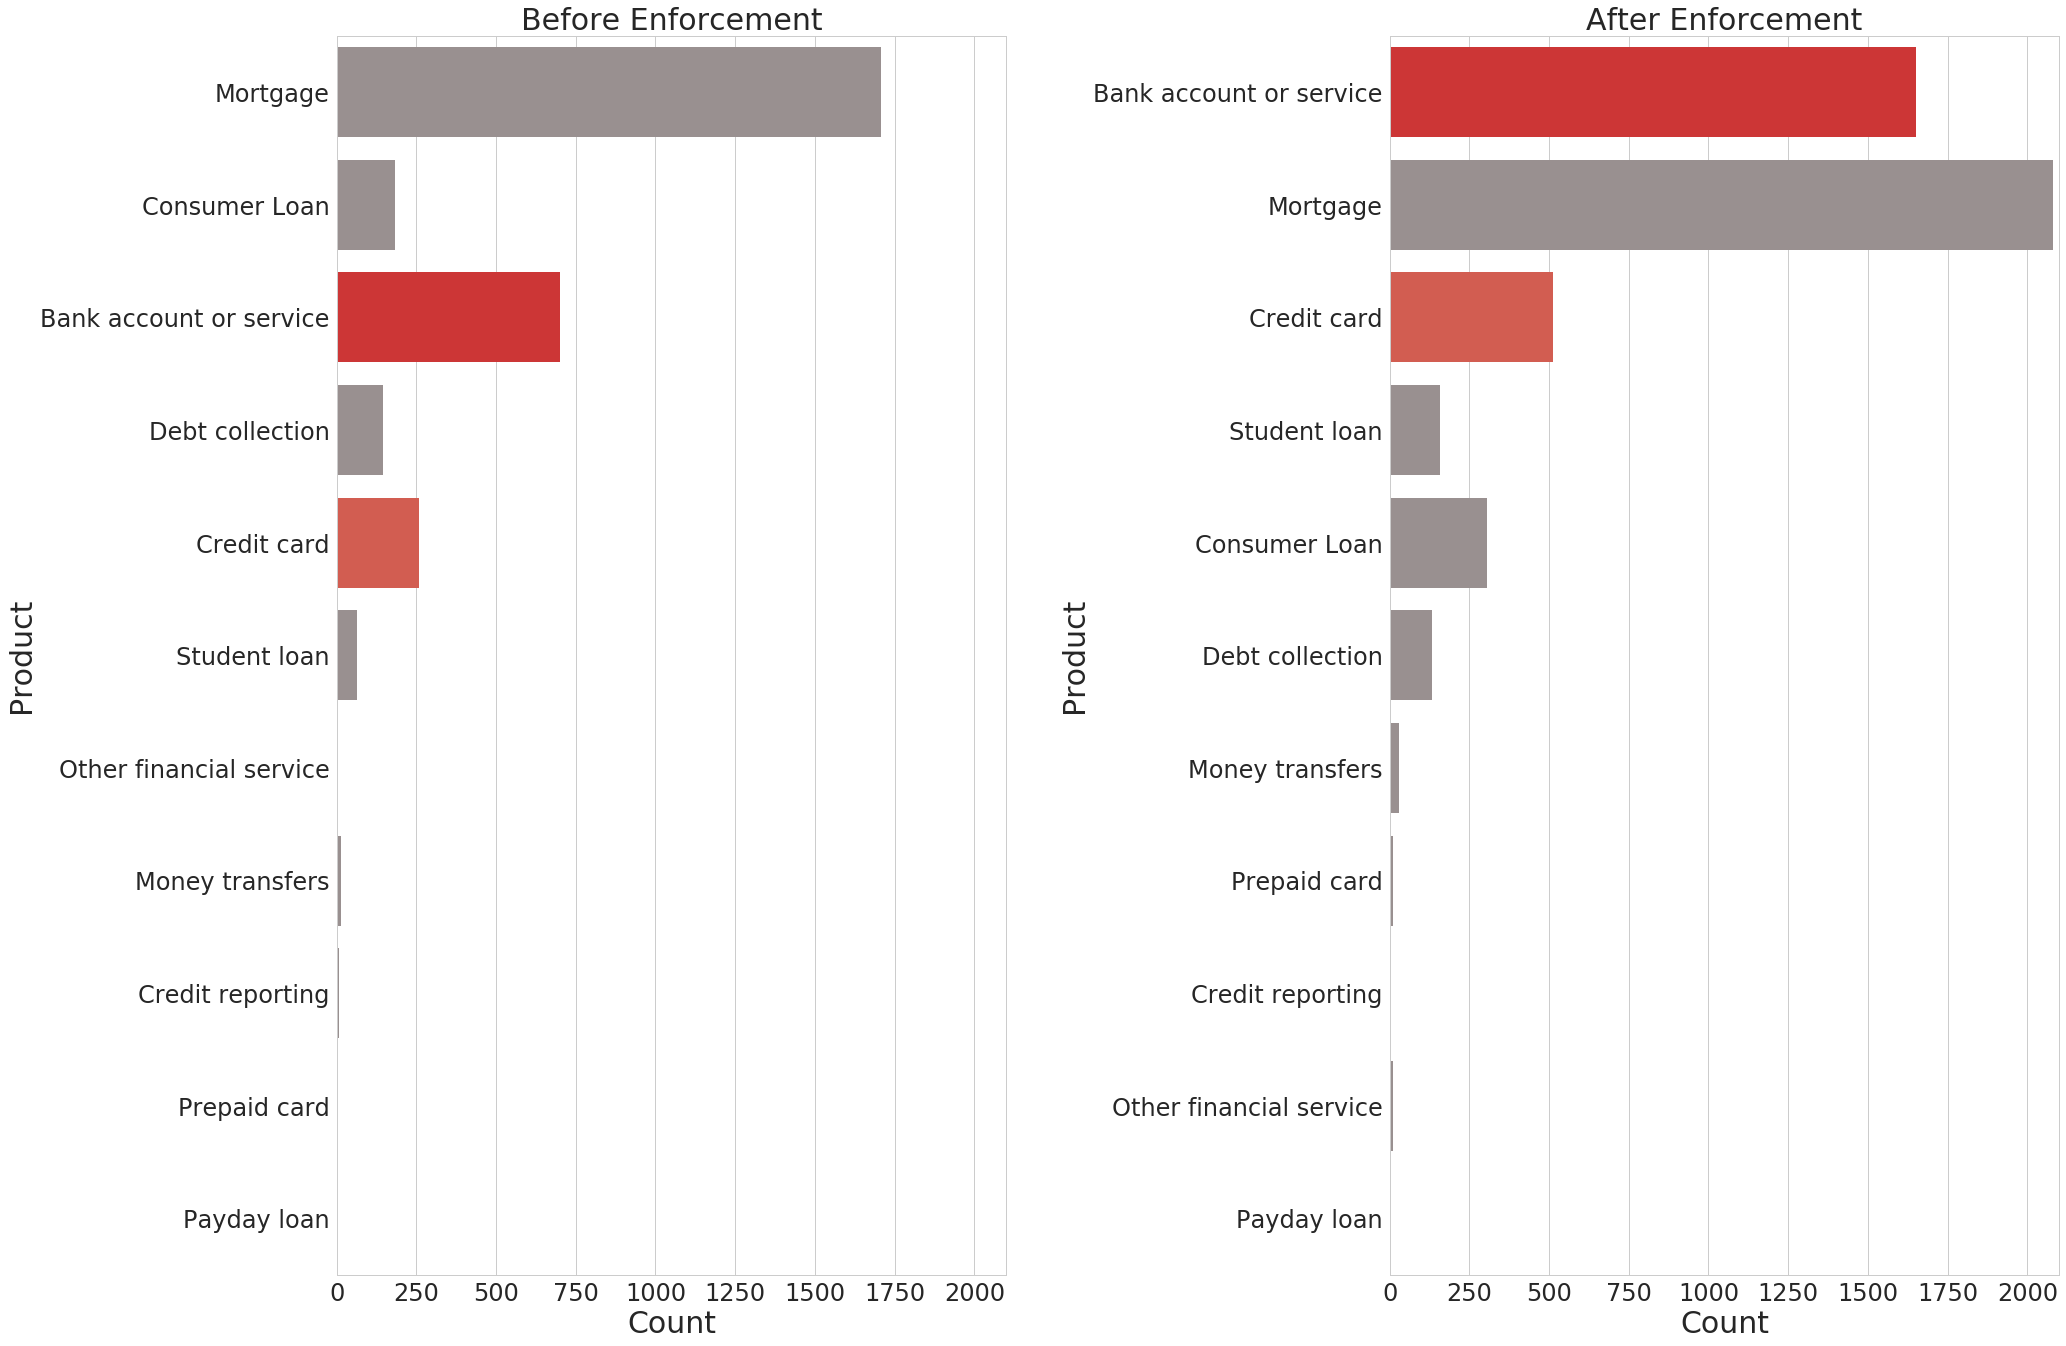

In [278]:
plt.rcParams.update({'font.size': 50})

fig,ax = plt.subplots(1,2,figsize=(30,20))
before_color = ['#9a8f8f','#9a8f8f','#e51d1d','#9a8f8f','#e74c3c','#9a8f8f','#9a8f8f','#9a8f8f','#9a8f8f','#9a8f8f','#9a8f8f','#9a8f8f']
after_color = ["#e51d1d",'#9a8f8f','#e74c3c','#9a8f8f','#9a8f8f','#9a8f8f','#9a8f8f','#9a8f8f','#9a8f8f','#9a8f8f','#9a8f8f','#9a8f8f']
ax1 = sns.countplot(y=d2[(d2.date_received<wells_enforcement)&
         (d2.date_received>wf_prior)]['product'],ax=ax[0],palette=before_color)
ax2 = sns.countplot(y=d2[(d2.date_received>wells_enforcement)&
         (d2.date_received<wf_post)]['product'],ax=ax[1],palette=after_color)
# ax0 = sns.countplot(y=d2['product'],ax=ax[0],palette="Blues_d")
fig.subplots_adjust(top=1.9)
# fig.suptitle('WF products before & after enforcement') # can also get the figure from plt.gcf()


ax1.set_xlabel("Count",fontsize=30)
ax2.set_xlabel("Count",fontsize=30)
ax1.set_ylabel("Product",fontsize=30)
ax2.set_ylabel("Product",fontsize=30)
ax1.tick_params(labelsize=24)
ax2.tick_params(labelsize=24)
ax1.set_title('Before Enforcement',fontsize=30)
ax2.set_title('After Enforcement',fontsize=30)
# ax2.title.set_text('After Enforcement')
# ax0.title.set_text('All Complaints')
ax1.set_xlim([0,2100])
ax2.set_xlim([0,2100])
plt.tight_layout()
fig.show()
fig.savefig('/Users/austinbrian/dev/blog/images/cfpb/wells_products_4_mo.png')

In [166]:
# use a function to test different columns and companies
def company_dist(company,topic_size=None,col='product',
                 enforcement_date=pd.datetime(2012,1,1)):
    cf = data[data['company']==company]
    cf_before_enforcement = cf.date_received<enforcement_date
    cf_after_enforcement = cf.date_received>enforcement_date
    df = pd.DataFrame()
    if topic_size is not None:
        model = models.ldamodel.LdaModel.load('../topic_tests/model_{}_topics.model'.format(topic_size))
        cf['topic'] = cf['complaint_what_happened'].progress_map(ldaquery)
        df['topic'] = [model.print_topic(i) for i in df.index]
    df['before'] = cf[cf_before_enforcement][col].value_counts()
    df['pct_before'] = 100*(cf[cf_before_enforcement][col].value_counts()/cf[cf_before_enforcement][col].value_counts().sum())
    df['after']=cf[cf_after_enforcement][col].value_counts()
    df['pct_after'] = 100*(cf[cf_after_enforcement][col].value_counts()/cf[cf_after_enforcement][col].value_counts().sum())
    return df

In [108]:
data = data.sort_values(by='date_received',ascending=False)
data[data.company == boa].tail()

,complaint_what_happened,product,date_received,tokens,company
87373,"Bank of America has endorsed and erected an "" ...",10,2015-03-20,bank america endors erect intang system cultur...,"BANK OF AMERICA, NATIONAL ASSOCIATION"
75742,Repeated calls being informed that they are tr...,7,2015-03-20,repeat call inform tri serv legal document mis...,"BANK OF AMERICA, NATIONAL ASSOCIATION"
82762,i was looking at my credit card statement from...,3,2015-03-20,look credit card statement bestbuy saw charg,"BANK OF AMERICA, NATIONAL ASSOCIATION"
93793,account reported as discharged through bankrup...,5,2015-03-19,account report discharg bankruptci chapter act...,"BANK OF AMERICA, NATIONAL ASSOCIATION"
131744,Wells Fargo Mortgage began foreclosure action ...,10,2015-03-19,well fargo mortgag began foreclosur action due...,"BANK OF AMERICA, NATIONAL ASSOCIATION"


In [102]:
for i in data.company.unique():
    i = str(i)
    if "OCWEN" in i:
        try:
            print i
        except TypeError:
            pass
    

OCWEN LOAN SERVICING LLC


In [83]:
boa = 'BANK OF AMERICA, NATIONAL ASSOCIATION'
enforcement_date = pd.datetime(2014,9,14)
boa_topics = company_dist(company=boa,enforcement_date=enforcement_date,topic_size=50,col='topic')b

progress-bar: 100%|██████████| 1390/1390 [04:14<00:00,  6.26it/s]
/Users/austinbrian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,topic,before,pct_before,after,pct_after
31,NaN,NaN,NaN,284,20.431655
17,NaN,NaN,NaN,275,19.784173
27,NaN,NaN,NaN,130,9.352518
4,NaN,NaN,NaN,78,5.611511
14,NaN,NaN,NaN,78,5.611511
7,NaN,NaN,NaN,67,4.820144
6,NaN,NaN,NaN,37,2.661871
19,NaN,NaN,NaN,36,2.589928
24,NaN,NaN,NaN,34,2.446043
38,NaN,NaN,NaN,33,2.374101


In [ ]:
wfa = 'WELLS FARGO BANK, NATIONAL ASSOCIATION'
wf_40_topics = company_dist(company=wfa,enforcement_date=wells_enforcement,
                            topic_size=40,col='topic')
wf_40_topis.head()

progress-bar:  54%|█████▍    | 744/1382 [02:20<01:55,  5.55it/s]

In [182]:
wfa = 'WELLS FARGO BANK, NATIONAL ASSOCIATION'
wf_30_topics = company_dist(company=wfa,enforcement_date=wells_enforcement,
                            topic_size=30,col='topic')
wf_30_topics.head()

progress-bar: 100%|██████████| 1382/1382 [04:21<00:00,  5.87it/s]
/Users/austinbrian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,topic,before,pct_before,after,pct_after
31,NaN,195,20.634921,96.0,22.170901
17,NaN,182,19.259259,81.0,18.706697
27,NaN,93,9.841270,36.0,8.314088
4,NaN,64,6.772487,25.0,5.773672
14,NaN,45,4.761905,29.0,6.697460


In [194]:
company_dist(wfa, enforcement_date=wells_enforcement,topic_size=50, col='product')

progress-bar: 100%|██████████| 1382/1382 [04:19<00:00,  5.78it/s]
/Users/austinbrian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,topic,before,pct_before,after,pct_after
7,NaN,222,23.492063,91.0,21.016166
10,NaN,215,22.751323,78.0,18.013857
5,NaN,190,20.105820,95.0,21.939954
3,NaN,105,11.111111,52.0,12.009238
0,NaN,94,9.947090,45.0,10.392610
2,NaN,52,5.502646,18.0,4.157044
15,NaN,42,4.444444,41.0,9.468822
9,NaN,10,1.058201,6.0,1.385681
14,NaN,7,0.740741,2.0,0.461894
12,NaN,7,0.740741,4.0,0.923788


In [196]:
cfpb[cfpb.company==wfa].head()

,company,company_public_response,company_response,complaint_id,complaint_what_happened,consumer_consent_provided,consumer_disputed,date_received,date_sent_to_company,issue,product,state,sub_issue,sub_product,submitted_via,tags,timely,zip_code
29,"WELLS FARGO BANK, NATIONAL ASSOCIATION",Company has responded to the consumer and the ...,Closed with explanation,2388517,NaN,NaN,No,2017-03-15,2017-03-16T00:00:00.000,"Loan modification,collection,foreclosure",Mortgage,NY,NaN,Other mortgage,Referral,NaN,Yes,11214
30,"WELLS FARGO BANK, NATIONAL ASSOCIATION",Company has responded to the consumer and the ...,Closed with explanation,2414476,NaN,NaN,No,2017-03-31,2017-03-31T00:00:00.000,"Loan modification,collection,foreclosure",Mortgage,CA,NaN,Home equity loan or line of credit,Postal mail,NaN,Yes,95404
38,"WELLS FARGO BANK, NATIONAL ASSOCIATION",Company has responded to the consumer and the ...,Closed with explanation,2420235,I do not feel I 've been getting fair opportun...,Consent provided,No,2017-04-06,2017-04-06T00:00:00.000,"Loan modification,collection,foreclosure",Mortgage,MD,NaN,FHA mortgage,Web,NaN,Yes,207XX
59,"WELLS FARGO BANK, NATIONAL ASSOCIATION",Company has responded to the consumer and the ...,Closed with explanation,2439795,NaN,NaN,No,2017-04-18,2017-04-18T00:00:00.000,"Loan servicing, payments, escrow account",Mortgage,CA,NaN,Conventional fixed mortgage,Web,NaN,Yes,951XX
67,"WELLS FARGO BANK, NATIONAL ASSOCIATION",Company has responded to the consumer and the ...,Closed with explanation,2446753,NaN,NaN,No,2017-04-21,2017-04-25T00:00:00.000,"Loan servicing, payments, escrow account",Mortgage,MN,NaN,Home equity loan or line of credit,Postal mail,Older American,Yes,55439


In [229]:
data['product'].value_counts()

7     38970
10    32107
5     30461
3     18350
0     14549
15    10312
2      9089
12     1699
9      1448
14     1408
11      275
17       16
Name: product, dtype: int64

In [230]:
cfpb[cfpb.complaint_what_happened.notnull()]['product'].value_counts()

Debt collection            39086
Mortgage                   32149
Credit reporting           30561
Credit card                18383
Bank account or service    14566
Student loan               10351
Consumer Loan               9115
Payday loan                 1703
Money transfers             1450
Prepaid card                1411
Other financial service      276
Virtual currency              16
Name: product, dtype: int64

In [227]:
wf.head()

,complaint_what_happened,product,date_received,tokens,topic
39,XXXX has wrongfully placed an account in colle...,5,2017-03-06,wrong place account collect indic owe water bi...,27
229,I have been an XXXX customer since it acquired...,7,2017-03-06,custom sinc acquir late cel phone number sinc ...,31
322,In XX/XX/2015 I had a checking account with Ba...,0,2017-04-06,check account bank america time work local pai...,27
351,A computer showed up at my home that I did not...,7,2017-03-06,comput show home order contact sender said wou...,7
390,I am writing in reference to a collection agen...,7,2017-03-07,write refer collect agenc recent receiv two le...,14


3090 total complaints before
4896 total complaints after
81 complaints w/narrative before
83 complaints w/narrative after


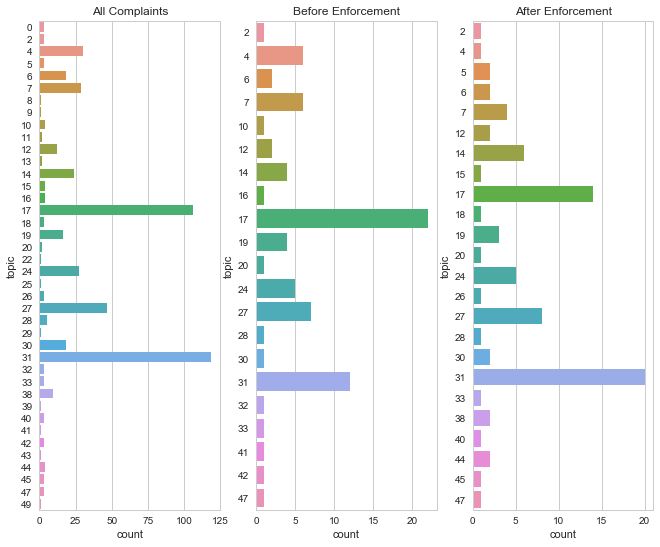

In [231]:
wf = wf[(wf.topic.notnull())&wf['product']==0]

offset = pd.DateOffset(months=4) # change this to look at different lengths of time
wf_prior = wells_enforcement-offset
wf_post = wells_enforcement+offset

wf_pd_before= (wf.date_received<wells_enforcement)&(wf.date_received>wf_prior)
wf_pd_after = (wf.date_received>wells_enforcement)&(wf.date_received<wf_post)

comp = 'WELLS FARGO BANK, NATIONAL ASSOCIATION'
d2 = cfpb[cfpb.company==comp]
len(d2[(d2.date_received<wells_enforcement)&
         (d2.date_received>wf_prior)])

print("{} total complaints before".format(len(d2[(d2.date_received<wells_enforcement)&
         (d2.date_received>wf_prior)])))
print("{} total complaints after".format(len(d2[(d2.date_received>wells_enforcement)&
         (d2.date_received<wf_post)])))

print("{} complaints w/narrative before".format(wf[wf_pd_before].topic.value_counts().sum()))
print("{} complaints w/narrative after".format(wf[wf_pd_after].topic.value_counts().sum()))
    

fig,ax = plt.subplots(1,3,figsize=(11,9))
ax1 = sns.countplot(y=wf[wf_pd_before].topic,ax=ax[1])
ax2 = sns.countplot(y=wf[wf_pd_after].topic,ax=ax[2])
ax0 = sns.countplot(y=wf.topic,ax=ax[0])
ax1.title.set_text('Before Enforcement')
ax2.title.set_text('After Enforcement')
ax0.title.set_text('All Complaints')
plt.tight_layout
fig.show()